In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from nilearn.input_data import NiftiLabelsMasker
from sklearn.decomposition import NMF
from nilearn.image import resample_to_img
from factor_analyzer import FactorAnalyzer
import matplotlib
from nilearn import datasets as ds
from nilearn import image
from neuromaps.stats import compare_images
import pymc3 as pm

Initialize

In [ ]:
export_figures = True
PATH = "..."
scaler = StandardScaler()
imp = SimpleImputer(missing_values=999,strategy="median")

In [2]:
# Initialize plotting
matplotlib.rcParams["svg.fonttype"] = "none"
plt.rcParams.update({"font.family": "Helvetica Neue"})
cm = 1 / 2.54  # centimeters in inches

color = ['#3f005c', '#ffa600']
my_colors = []
for c in color:
    my_colors.append(matplotlib.colors.to_rgb(c))


Prepare dataset

In [ ]:
# Load lesion load data
lesion_load = pd.read_csv(PATH + "data.csv")
lesion_load = lesion_load.drop(columns="Unnamed: 0")
lesion_bilat = lesion_load.iloc[:1401].copy()
lesion_bilat = lesion_bilat.rename(columns={"0": "Left"})
lesion_bilat["Right"] = np.array(lesion_load.iloc[1401:])

In [ ]:
# Load behavioral data
Behav = pd.read_excel(PATH + 'behavioral.xlsx')
Behav = Behav[np.invert((lesion_bilat!=0).all(axis=1))]  # excluding patients with bilateral lesions
# Imputing missing values with median
Behav_imp = pd.DataFrame(imp.fit_transform(Behav))
Behav_imp.columns = Behav.columns
# Average time for TMT A and B
Behav_imp['TMT_Time_zscore_neg'] = np.mean([Behav_imp.TMT_A_Time_zscore_neg, Behav_imp.TMT_B_Time_zscore_neg], axis=0)

In [ ]:
# Extra behavioral measures
Behav_extra = pd.read_excel(PATH + 'behav_extended.xlsx')
Behav_extra = Behav_extra[Behav_extra.ID.isin(Behav_imp.ID)]
Behav_extra_imp = pd.DataFrame(imp.fit_transform(Behav_extra))
Behav_extra_imp.columns = Behav_extra.columns
Behav_imp['SemanticFluency'] = scaler.fit_transform(Behav_extra_imp.Semanticfluencyanimal.values.reshape(-1, 1))
Behav_imp['PhonemicFluency'] = scaler.fit_transform(Behav_extra_imp.Phonemicfluency_total.values.reshape(-1, 1))
Behav_imp['DigitSymbolCoding'] = scaler.fit_transform(Behav_extra_imp.DigitSymbolCoding_correct.values.reshape(-1, 1))
Behav_imp = Behav_imp.drop(columns=["ID","Cohort"])
# Scaling the total infarct volume
Total_infarct_volume_scaled = scaler.fit_transform(np.array(Behav_imp.Total_infarct_volume).reshape(-1, 1))
Behav_imp["Total_infarct_volume_scaled"] = Total_infarct_volume_scaled
# Collapsing the data
Behav_imp_collapsed = pd.concat([Behav_imp, Behav_imp], axis=0)
Behav_imp_collapsed.index = range(0,2160)

In [ ]:
# Load lesion masks
subject_names = glob.glob(PATH + '/lesionmaps/*',)
subject_names = sorted(subject_names)
# Load atlas
dataset = ds.fetch_atlas_harvard_oxford('cort-maxprob-thr50-2mm', symmetric_split=True)
cortical_mask = dataset.maps
cortical_labels = dataset.labels
dataset = ds.fetch_atlas_harvard_oxford('sub-maxprob-thr50-2mm')
subcortical_mask = dataset.maps
subcortical_labels = dataset.labels
# Edit the labels
cortical_labels = pd.DataFrame(cortical_labels)
cortical_labels = cortical_labels.drop(index=[0,93,94])
subcortical_labels = pd.DataFrame(subcortical_labels)
subcortical_labels = subcortical_labels.drop(index=[0,1,2,3,12,13,14])

In [ ]:
# Loading mapped to cortical and subcortical regions
cortical = pd.read_csv(PATH + "/cortical.csv")
cortical = cortical.drop(columns="Unnamed: 0")
subcortical = pd.read_csv(PATH + "/subcortical.csv")
subcortical = subcortical.drop(columns="Unnamed: 0")

# resample one sub to the cortical mask
cortical_resampled_stat_img = resample_to_img(cortical_mask, subject_names[0], interpolation='nearest')
# resample one subject to subcortical mask
subcortical_resampled_stat_img = resample_to_img(subcortical_mask, subject_names[0], interpolation='nearest')
# count voxels in a region
cortical_count_labels = np.bincount(cortical_resampled_stat_img.get_data().astype(np.int64).ravel())
subcortical_count_labels = np.bincount(subcortical_resampled_stat_img.get_data().astype(np.int64).ravel())

In [ ]:
# Extracting the labels
cortical_count_labels = pd.DataFrame(cortical_count_labels)
cortical_count_labels = np.array(cortical_count_labels.drop(index=[0,93,94])).ravel()
subcortical_count_labels = pd.DataFrame(subcortical_count_labels)
subcortical_count_labels = np.array(subcortical_count_labels.drop(index=[0, ])).ravel()

# number of lesion in each region
cortical_lesion_count_absolute = cortical*cortical_count_labels
subcortical_lesion_count_absolute = subcortical*subcortical_count_labels
subcortical_lesion_count_absolute = subcortical_lesion_count_absolute.drop(columns=["0","1","2","11","12","13"])

In [ ]:
# Renaming the columns
cortical_lesion_count_absolute.columns = cortical_labels
subcortical_lesion_count_absolute.columns = subcortical_labels

new_columns = []
for parcel in range(len(cortical_lesion_count_absolute.columns)):
        new_columns.append(cortical_lesion_count_absolute.columns[parcel][0].replace(" ", "_"))
cortical_lesion_count_absolute.columns = new_columns

new_columns = []
for parcel in range(0, len(subcortical_lesion_count_absolute.columns)):
        new_columns.append(subcortical_lesion_count_absolute.columns[parcel][0].replace(" ", "_"))
subcortical_lesion_count_absolute.columns = new_columns

subcortical_lesion_count_absolute = subcortical_lesion_count_absolute.drop(columns=['Brain-Stem'])

# reduce to non-bilateral
cortical_lesion_count_absolute = cortical_lesion_count_absolute[np.invert((lesion_bilat!=0).all(axis=1))]

In [ ]:
# Splitting the data into left and right hemisphere
cortical_lesion_left = cortical_lesion_count_absolute.iloc[:,range(0,94,2)]
cortical_lesion_left.loc[:,"Left_hemisphere"] = 0
cortical_lesion_right = cortical_lesion_count_absolute.iloc[:,range(1,95,2)]
cortical_lesion_right.loc[:,"Left_hemisphere"] = 1

for hem, hem_name in zip([cortical_lesion_right, cortical_lesion_left], ["Right_", "Left_"]):
    new_columns = []
    for parcel in range(0, len(hem.columns[:-1])):
            new_columns.append(hem.columns[parcel].replace(hem_name, ""))
    new_columns.append("Left_hemisphere")
    hem.columns = new_columns

cortical_lesion_collapsed = pd.concat([cortical_lesion_left, cortical_lesion_right])

In [ ]:
# Splitting the data into left and right hemisphere
subcortical_lesion_count_absolute = subcortical_lesion_count_absolute[np.invert((lesion_bilat!=0).all(axis=1))]

subcortical_lesion_left = subcortical_lesion_count_absolute.iloc[:,range(0,7,1)]
subcortical_lesion_left.loc[:,"Left_hemisphere"] = 0
subcortical_lesion_right = subcortical_lesion_count_absolute.iloc[:,range(7,14,1)]
subcortical_lesion_right.loc[:,"Left_hemisphere"] = 1

for hem, hem_name in zip([subcortical_lesion_right, subcortical_lesion_left], ["Right_", "Left_"]):
    new_columns = []
    for parcel in range(0, len(hem.columns[:-1])):
            new_columns.append(hem.columns[parcel].replace(hem_name, ""))
    new_columns.append("Left_hemisphere")
    hem.columns = new_columns

subcortical_lesion_collapsed = pd.concat([subcortical_lesion_left, subcortical_lesion_right])

In [ ]:
lesions_collapsed_all = pd.concat([cortical_lesion_collapsed, subcortical_lesion_collapsed], axis=1)
lesions_collapsed_hemisphere = lesions_collapsed_all["Left_hemisphere"].copy()
lesions_collapsed_hemisphere = np.array(lesions_collapsed_hemisphere)
lesions_collapsed_all = lesions_collapsed_all.drop(columns="Left_hemisphere")


In [ ]:
hemisphere_idx = lesions_collapsed_hemisphere[:,0]
n_hemispheres = len(np.unique(lesions_collapsed_hemisphere))
n_components = 10

Prepare covariates

In [33]:
Age_mean_scaled = Behav_imp["Age"] - Behav_imp["Age"].mean()
Age_mean_scaled = np.concatenate((Age_mean_scaled, Age_mean_scaled))
Age_mean_scaled_2 = np.array(Age_mean_scaled * Age_mean_scaled)

Behav_imp_collapsed["Sex_1_m"] = Behav_imp_collapsed["Sex"].replace(1, 0)
Behav_imp_collapsed["Sex_1_m"] = Behav_imp_collapsed["Sex_1_m"].replace(2, 1)
Sex_m = np.int64(np.array(Behav_imp_collapsed["Sex_1_m"]))
Behav_imp_collapsed["Sex_1_w"] = Behav_imp_collapsed["Sex"].replace(2, 0)
Sex_w = np.int64(np.array(Behav_imp_collapsed["Sex_1_w"]))

Age_Sex_m = Age_mean_scaled * Sex_m
Age_Sex_w = Age_mean_scaled * Sex_w

Lesion_vol_scaled = np.array(Behav_imp_collapsed.Total_infarct_volume_scaled)


In [35]:
# Behavioral measures
Education_mean_scaled = Behav_imp["Education_years"] - \
    Behav_imp["Education_years"].mean()
Education_mean_scaled = np.concatenate(
    (Education_mean_scaled, Education_mean_scaled))
Education_mean_scaled = np.array(Education_mean_scaled)

IQ_mean_scaled = Behav_imp["IQCODE"] - Behav_imp["IQCODE"].mean()
# double Age_scaled for hierarchical approach
IQ_mean_scaled = np.concatenate((IQ_mean_scaled, IQ_mean_scaled))
IQ_mean_scaled = np.array(IQ_mean_scaled)

MMSE = np.array(Behav_imp_collapsed.MMSE_total_zscore.values)

In [ ]:
# Input data
X1 = Behav_imp_collapsed.MMSE_total_zscore.values
X2 = Behav_imp_collapsed.ReyComplexFigureTestCopy_zscore.values
X3 = Behav_imp_collapsed.BostonNamingTest_zscore.values
X4 = Behav_imp_collapsed.Seoul_Verbal_Learning_Test_immediate_recall_total_zscore.values
X5 = Behav_imp_collapsed.TMT_Time_zscore_neg.values
X6 = Behav_imp_collapsed.SemanticFluency.values
X7 = Behav_imp_collapsed.PhonemicFluency.values
X8 = Behav_imp_collapsed.DigitSymbolCoding.values
X = np.array([X1, X2, X3, X4, X5, X6, X7, X8])
cat_names = ['Mini-Mental State', 'Rey Complex Figure', 'Boston Naming',
             'Seoul Verbal Learning', 'Trail Making', 'Semantic Fluency',
             'Phonemic Fluency', 'Digit Symbol Coding']

NMF transformation

In [38]:
# NMF log nmb of lesions na 10 komponent
nmf = NMF(n_components=10, init='random', random_state=0)
lesions_collapsed_all_nmf_abs_log = nmf.fit_transform(
    np.log(lesions_collapsed_all+1))

BHM model

In [40]:
# Univariate outcome
n_components = 10
with pm.Model() as hierarchical_all_parcels_education_log_model:
    b_all = ["b_1", "b_2", "b_3", "b_4", "b_5",
             "b_6", "b_7", "b_8", "b_9", "b_10"]
    mu = pm.Normal("a", mu=0, sd=1)
    sigma_b_hyper = pm.HalfCauchy("sigma_b_hyper",  1, shape=1)
    sigma_b_all = pm.HalfCauchy("sigma_b_all", sigma_b_hyper, shape=2)

    for i_component in range(n_components):
        cur_beta = pm.Normal(b_all[i_component], mu=0, sd=sigma_b_all, shape=2)
        mu = mu + cur_beta[hemisphere_idx] * \
            lesions_collapsed_all_nmf_abs_log[:, i_component]

    cov1_beta = pm.Normal("cov1_lesions", mu=0, sd=10, shape=1)
    cov2_beta = pm.Normal("cov2_age", mu=0, sd=10, shape=1)
    cov3_beta = pm.Normal("cov3_age_2", mu=0, sd=10, shape=1)
    cov4_beta = pm.Normal("cov4_sex_m", mu=0, sd=1, shape=1)
    cov5_beta = pm.Normal("cov5_sex_w", mu=0, sd=1, shape=1)
    cov6_beta = pm.Normal("cov6_ed_years", mu=0, sd=5, shape=1)
    cov7_beta = pm.Normal("cov7_IQCode", mu=0, sd=1, shape=1)
    mu = mu + cov1_beta*Lesion_vol_scaled + cov2_beta*Age_mean_scaled + cov3_beta*Age_mean_scaled_2 + cov4_beta*Sex_m + \
        cov5_beta*Sex_w + cov6_beta * Education_mean_scaled + cov7_beta*IQ_mean_scaled

    # Model error
    eps = pm.HalfCauchy('eps', 20)

    # Data likelihood
    TO_uv = pm.Normal('TO_uv', mu=mu, sd=eps, observed=X)


In [41]:
# Load the trace
b_all = []
b_left = []
b_right = []
b_inverse = []
nmf_left = []
nmf_right = []
nmf_left_ms = []
nmf_right_ms = []
mask_vars = []
mask = []
for j in range(4):
    with hierarchical_all_parcels_education_log_model:
        hierarchical_all_parcels_education_log_trace = pm.load_trace(
            PATH + "/unimodal_fa_v" + str(j+1) + ".trace")

    # left betas
    tmp_left = []
    # for i, i_nmf in zip(range(1, 11), range(10)):
    for i in np.arange(1, n_components+1):
        tmp_left.append(pd.DataFrame(
            hierarchical_all_parcels_education_log_trace[1000:]["b_%i" % i])[0].mean())
    tmp_left_inverse = nmf.inverse_transform(tmp_left)
    nmf_left.append(tmp_left)

    # right betas
    tmp_right = []
    for i in np.arange(1, n_components+1):
        tmp_right.append(pd.DataFrame(
            hierarchical_all_parcels_education_log_trace[1000:]["b_%i" % i])[1].mean())
    tmp_right_inverse = nmf.inverse_transform(tmp_right)
    nmf_right.append(tmp_right)

    tmp_inverse = pd.DataFrame(tmp_left_inverse)
    tmp_inverse = tmp_inverse.rename(columns={0: "left"})
    tmp_inverse["right"] = pd.DataFrame(tmp_right_inverse)
    b_inverse.append(tmp_inverse)

    # Scale regional loadings
    b = np.concatenate((tmp_left_inverse, tmp_right_inverse))
    b = np.matrix.flatten(scaler.fit_transform(b.reshape(-1, 1)))
    b_all.append(np.abs(b))

    tmp_left_inverse = b[0:int(len(b)/2)]
    tmp_right_inverse = b[int(len(b)/2):len(b)]

    b_left.append(np.abs(np.matrix.flatten(tmp_left_inverse)))
    b_right.append(np.abs(np.matrix.flatten(tmp_right_inverse)))

    # Scale NMF loadings
    b = (np.concatenate((tmp_left, tmp_right)))
    b = np.matrix.flatten(scaler.fit_transform(b.reshape(-1, 1)))
    tmp_left = b[0:int(len(b)/2)]
    tmp_right = b[int(len(b)/2):len(b)]

    nmf_left_ms.append(np.abs(np.matrix.flatten(tmp_left)))
    nmf_right_ms.append(np.abs(np.matrix.flatten(tmp_right)))


In [ ]:
# fit maskers
ho_cor = ds.fetch_atlas_harvard_oxford(
    'cort-maxprob-thr0-2mm', symmetric_split=True)
ho_sub = ds.fetch_atlas_harvard_oxford(
    'sub-maxprob-thr0-2mm', symmetric_split=False)
cortical_region = np.concatenate((np.ones(48, dtype=bool),
                                  np.zeros(17, dtype=bool)))
subcortical_region = np.concatenate((np.zeros(48, dtype=bool),
                                     np.ones(7, dtype=bool),
                                     np.zeros(10, dtype=bool)))

subcort_oder = [5, 1, 4, 3, 2, 0, 6]
ho_cor_rois = np.array(ho_cor.labels, dtype=str)
ho_sub_rois = np.array(ho_sub.labels, dtype=str)
masker_cor = NiftiLabelsMasker(labels_img=ho_cor.maps, standardize=False,
                               memory='nilearn_cache')
masker_cor.fit()
masker_sub = NiftiLabelsMasker(labels_img=ho_sub.maps, standardize=False,
                               memory='nilearn_cache')
masker_sub.fit()

In [43]:
# Plot on brain
language_net = image.load_img(
    PATH+'/Data/Language/allParcels_language_SN220.nii')
language_net = image.math_img("(img>0)*1+0.00001", img=language_net)

demand_net = image.load_img(PATH+'/Data/Language/allParcels_MD_HE197.nii')
demand_net = image.math_img("(img>0)*1+0.00001", img=demand_net)

r_language = []
r_demand = []
ov_language = []
ov_demand = []
for i in range(4):
    tmp_inverse = b_inverse[i]
    x = (np.array(tmp_inverse.transpose()))
    x = np.abs(x)

    # Cortical
    x1 = x[0, :47]
    x2 = x[1, :47]
    data_cor = np.zeros(2*len(x1))
    data_cor[0::2] = x1
    data_cor[1::2] = x2

    data_cor = np.insert(data_cor, 93, 0)
    data_cor = np.insert(data_cor, 94, 0)
    data_cor = np.reshape((data_cor), (-1, 1))

    nifti_cor = masker_cor.inverse_transform(data_cor.T)
    A = masker_cor.transform(nifti_cor)

    # Subcortical
    x1 = x[0, 47:]
    x2 = x[1, 47:]

    data_sub = np.concatenate((np.zeros(3), x1, np.zeros(4), x2))
    data_sub = np.reshape((data_sub), (-1, 1))
    nifti_sub = masker_sub.inverse_transform(data_sub.T)

    nifti = image.mean_img(nifti_cor)


    nifti_ov_lan = image.math_img("img1 * img2",
                                  img1=language_net, img2=nifti)
    nifti_ov_dem = image.math_img("img1 * img2",
                                  img1=demand_net, img2=nifti)
    ov_language.append(np.sum(masker_cor.transform(nifti_ov_lan)) /
                       np.sum(data_cor)/np.sum(masker_cor.transform(language_net)))
    ov_demand.append(np.sum(masker_cor.transform(nifti_ov_dem)) /
                     np.sum(data_cor)/np.sum(masker_cor.transform(language_net)))

    r_language.append(compare_images(nifti, language_net))
    r_demand.append(compare_images(nifti, demand_net))


In [44]:
def change_width(ax, new_value):
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


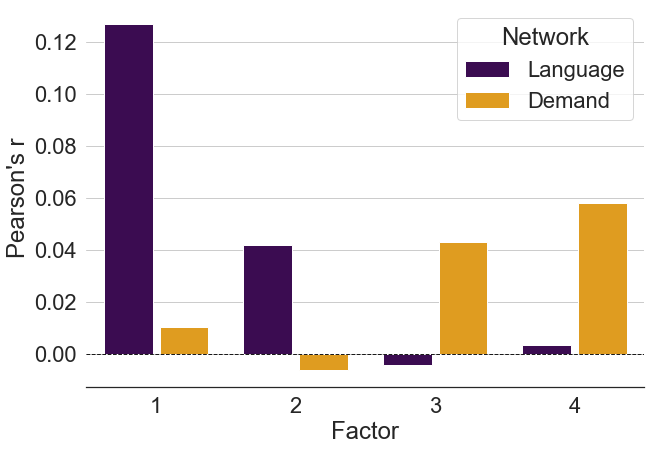

In [45]:
df = pd.DataFrame({'Language': r_language, 'Demand': r_demand})
df = pd.melt(df, ignore_index=False)
df = df.reset_index(drop=False)

sns.set_theme(style="white", palette='colorblind', font_scale=2)
fig, ax = plt.subplots(1, figsize=(10, 7))
g = sns.barplot(x='index', y='value', hue='variable', data=df,
                # order=reduced_regions[idx],
                palette=my_colors)
g.set_xticklabels(np.arange(1, 5))
# plt.xlim((-0.5, len(reduced_regions)-0.5))
# g.set_xlabel('')
plt.legend(title='Network')
ax.yaxis.grid()
sns.despine(left=True)
g.set_ylabel("Pearson's r")
g.set_xlabel("Factor")
plt.axhline(y=0, linestyle='--', linewidth=1, color='k')
change_width(ax, 0.35)
plt.show()


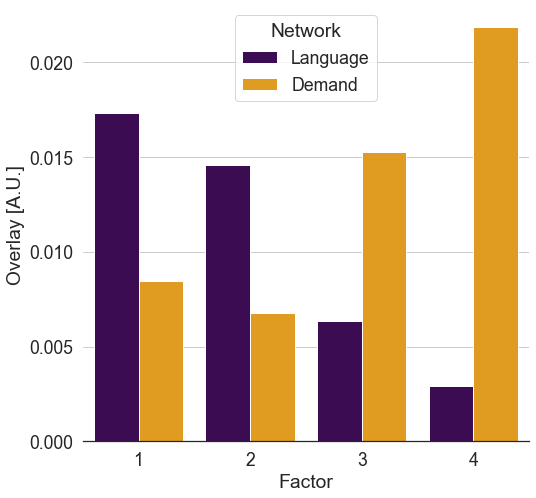

In [ ]:
df = pd.DataFrame({'Language': ov_language, 'Demand': ov_demand})
df = pd.melt(df, ignore_index=False)
df = df.reset_index(drop=False)

sns.set_theme(style="white", palette='colorblind', font_scale=1.6)
fig, ax = plt.subplots(1, figsize=(8, 8))
g = sns.barplot(x='index', y='value', hue='variable', data=df,
                # order=reduced_regions[idx],
                palette=my_colors)
g.set_xticklabels(np.arange(1, 5))
# plt.xlim((-0.5, len(reduced_regions)-0.5))
# g.set_xlabel('')
plt.legend(title='Network', loc='upper center')
ax.yaxis.grid()
sns.despine(left=True)
g.set_ylabel("Overlay [A.U.]")
g.set_xlabel("Factor")
plt.axhline(y=0, linestyle='--', linewidth=1, color='k')
plt.show()
